In [4]:
import os
import pandas as pd

uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)  
    return df

def count_files_per_class(df):
    return df['class_name'].value_counts()


train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'


train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

train_counts = count_files_per_class(train_uc_df)
val_counts = count_files_per_class(val_uc_df)
test_counts = count_files_per_class(test_uc_df)

print("Train set counts per emotion class:\n", train_counts)
print("\nValidation set counts per emotion class:\n", val_counts)
print("\nTest set counts per emotion class:\n", test_counts)


Train set counts per emotion class:
 anger        170
disgust      170
fear         168
surprise     165
sadness      160
happiness    157
Name: class_name, dtype: int64

Validation set counts per emotion class:
 surprise     42
fear         42
disgust      42
anger        42
sadness      41
happiness    40
Name: class_name, dtype: int64

Test set counts per emotion class:
 surprise     42
anger        42
fear         42
disgust      42
sadness      41
happiness    40
Name: class_name, dtype: int64


In [7]:
import os
import pandas as pd
from sklearn.utils import resample

def balance_dataframe(df):
    min_count = df['class_name'].value_counts().min()  
    balanced_df = pd.DataFrame()

    
    for class_name in df['class_name'].unique():
        class_subset = df[df['class_name'] == class_name]
        class_subset_balanced = resample(class_subset, replace=False, n_samples=min_count, random_state=42)
        balanced_df = pd.concat([balanced_df, class_subset_balanced])
    
    
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
    return balanced_df

train_uc_df = balance_dataframe(train_uc_df)
val_uc_df = balance_dataframe(val_uc_df)
test_uc_df = balance_dataframe(test_uc_df)

balanced_train_counts = count_files_per_class(train_uc_df)
balanced_val_counts = count_files_per_class(val_uc_df)
balanced_test_counts = count_files_per_class(test_uc_df)

print("Balanced Train set counts per emotion class:\n", balanced_train_counts)
print("\nBalanced Validation set counts per emotion class:\n", balanced_val_counts)
print("\nBalanced Test set counts per emotion class:\n", balanced_test_counts)


Balanced Train set counts per emotion class:
 sadness      157
surprise     157
anger        157
fear         157
disgust      157
happiness    157
Name: class_name, dtype: int64

Balanced Validation set counts per emotion class:
 disgust      40
surprise     40
anger        40
happiness    40
fear         40
sadness      40
Name: class_name, dtype: int64

Balanced Test set counts per emotion class:
 surprise     40
fear         40
happiness    40
disgust      40
sadness      40
anger        40
Name: class_name, dtype: int64


In [18]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  

input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  


train_uc_set = '/home/jovyan/vol-1/enterface_train'
val_uc_set = '/home/jovyan/vol-1/enterface_val'
test_uc_set = '/home/jovyan/vol-1/enterface_test'

uc_label2id = {'anger': 0, 'happiness': 1, 'surprise': 2, 'disgust': 3, 'fear': 4, 'sadness': 5}
uc_id2label = {v: k for k, v in uc_label2id.items()}


import pandas as pd

def create_uc_dataframe(path):
    data = []
    for video_file in os.listdir(path):
        if video_file.endswith('.mp4'):
            emotion = video_file.split('_')[1]  
            if emotion in uc_label2id:
                video_path = os.path.join(path, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': uc_label2id[emotion],
                    'class_name': emotion
                })
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)  
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])  
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices((df['video_path'].values, df['label'].values))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/vol-1/pretrainedmodel"
pretrained_model = tf.saved_model.load(model_path)


class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

with strategy.scope():
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))  # Input shape
    x = TFSMLayer(pretrained_model)(inputs)

    outputs = layers.Dense(len(uc_label2id), dtype='float32', activation=None)(x)

    
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,  
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
            keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc")
        ]
    )

model.summary()

history = model.fit(
    train_uc_ds,
    validation_data=val_uc_ds,
    steps_per_epoch=len(train_uc_df) // batch_size,
    validation_steps=len(val_uc_df) // batch_size,
    epochs=50,
)


2024-10-28 10:45:21.989671: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: A100-SXM4-40GB MIG 0g.5gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2024-10-28 10:45:23.448321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2983 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 0g.5gb, pci bus id: 0000:b7:00.0, compute capability: 8.0


Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 2406 (9.40 KB)
Trainable params: 2406 (9.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50


2024-10-28 10:45:39.444946: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 990
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2024-10-28 10:45:49.238462: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555a0358b450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 10:45:49.238518: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): A100-SXM4-40GB MIG 0g.5gb, Compute Capability 8.0
2024-10-28 10:45:49.936844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 10:45:51.975280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-10-28 10:45:57.754883: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 [==============================] - ETA: 0s - loss: 1.8000 - acc@1: 0.2348 - acc: 0.5891

2024-10-28 10:49:54.599907: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 249
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

247/247 [==============================] - 323s 1s/step - loss: 1.8000 - acc@1: 0.2348 - acc: 0.5891 - val_loss: 1.7187 - val_acc@1: 0.3024 - val_acc: 0.6855
Epoch 2/50
247/247 [==============================] - 305s 1s/step - loss: 1.6441 - acc@1: 0.3239 - acc: 0.6721 - val_loss: 1.6910 - val_acc@1: 0.2984 - val_acc: 0.7258
Epoch 3/50
247/247 [==============================] - 303s 1s/step - loss: 1.5934 - acc@1: 0.3603 - acc: 0.7055 - val_loss: 1.6515 - val_acc@1: 0.3629 - val_acc: 0.7460
Epoch 4/50
247/247 [==============================] - 310s 1s/step - loss: 1.5468 - acc@1: 0.3593 - acc: 0.7368 - val_loss: 1.6408 - val_acc@1: 0.3387 - val_acc: 0.7540
Epoch 5/50
247/247 [==============================] - 305s 1s/step - loss: 1.5111 - acc@1: 0.4089 - acc: 0.7419 - val_loss: 1.6365 - val_acc@1: 0.3387 - val_acc: 0.7419
Epoch 6/50
247/247 [==============================] - 302s 1s/step - loss: 1.4612 - acc@1: 0.4038 - acc: 0.7652 - val_loss: 1.6298 - val_acc@1: 0.3790 - val_acc: 0.77

In [19]:
evaluation = model.evaluate(test_uc_ds, return_dict=True)

accuracy = evaluation['acc'] 
top3_accuracy = evaluation.get('acc@1') 

print(f"Accuracy: {accuracy}")
print(f"Top-3 Accuracy: {top3_accuracy}")


2024-10-28 15:03:44.419362: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 249
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:9"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

62/62 [==============================] - 61s 972ms/step - loss: 1.3076 - acc@1: 0.5766 - acc: 0.8871
Accuracy: 0.8870967626571655
Top-3 Accuracy: 0.5766128897666931


1/1 [==============================] - 0s 128ms/step


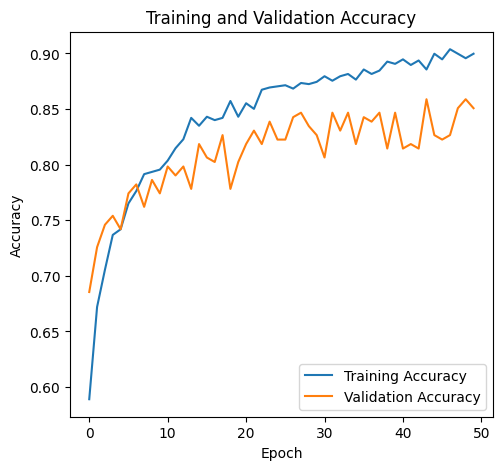

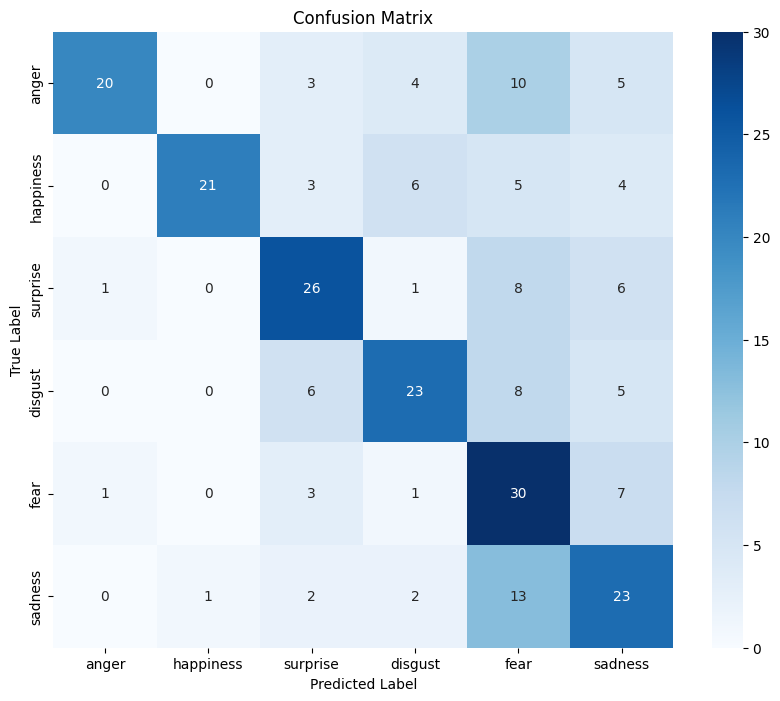

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    


plot_training_history(history)

def plot_confusion_matrix(model, dataset, label_mapping):
    y_true = []
    y_pred = []
    
    for videos, labels in dataset:
        predictions = model.predict(videos)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=list(label_mapping.keys()))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_uc_ds, uc_label2id)


In [41]:
model.save('/home/jovyan/vol-1/saved_model', save_format='tf')


INFO:tensorflow:Assets written to: /home/jovyan/vol-1/saved_model/assets


INFO:tensorflow:Assets written to: /home/jovyan/vol-1/saved_model/assets


In [47]:
import tensorflow as tf
print(tf.__version__)


2.13.0


In [7]:
import os
import numpy as np
import tensorflow as tf
from decord import VideoReader

input_size = 224
num_frame = 16

model_path = '/home/jovyan/vol-1/saved_model'
model = tf.keras.models.load_model(model_path)

def read_video(file_path):
    """Read and format video from the given file path."""
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frames, output_size):
    """Format frames by converting to float and resizing."""
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path):
    """Load a video and convert it to a tensor."""
    video = read_video(file_path)
    video = tf.convert_to_tensor(video, dtype=tf.float32)
    video = tf.expand_dims(video, axis=0)  
    return video


test_video_path = '/home/jovyan/vol-1/enterface_test/s21_sadness_3.mp4'

video_tensor = load_video(test_video_path)

predictions = model.predict(video_tensor)
predicted_class = np.argmax(predictions, axis=-1)[0]

uc_id2label = {0: 'anger', 1: 'happiness', 2: 'surprise', 3: 'disgust', 4: 'fear', 5: 'sadness'}
predicted_emotion = uc_id2label[predicted_class]

print(f'Predicted emotion class: {predicted_emotion}')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: A100-SXM4-40GB MIG 0g.5gb, compute capability 8.0


2024-10-28 16:16:33.495561: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2983 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 0g.5gb, pci bus id: 0000:b7:00.0, compute capability: 8.0
2024-10-28 16:16:51.256356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-10-28 16:16:51.623150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 3s 3s/step
Predicted emotion class: sadness
